# **APS1080: Introduction to Reinforcement Learning**
---
**Student Name**:
---



**Student ID:**

---
**Assignment 3:** TD(n) and Mountain Car


------

In this assignment we are going to apply the TD(n) methods to solve the Mountain Car problem.

By now, you should know how to load OpenAI gym environments:

env = gym.make('MountainCar-v0')

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install xvfb


In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from collections import defaultdict


In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

--------

# **Exercise** 1: Prelims

These are useful exercises to develop facility with the environment prior this assignment. Explore the above environment as we've done in past assignments and exercises.

Develop a MC controller and assess its performance.

Iterations that were run: 99


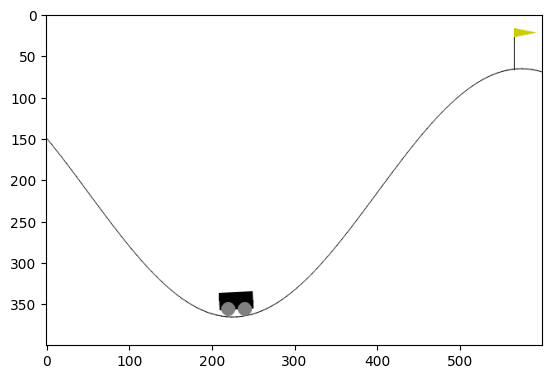

In [6]:
# Create the MountainCar environment for exploring the environment.

# Initialize the MountainCar environment from OpenAI Gym
env = gym.make("MountainCar-v0")

# Reset the environment to its initial state
env.reset()

# Render the initial frame as an RGB array
prev_screen = env.render(mode='rgb_array')

plt.imshow(prev_screen)  # Display the initial frame

# Run a random policy for a maximum of 100 steps
for i in range(100):
    action = env.action_space.sample()  # Sample a random action from the action space
    print("step i", i, "action=", action)  # Print the current step and chosen action
    obs, reward, done, info = env.step(action)  # Apply the action to the environment and get the results
    print("obs=", obs, "reward=", reward, "done=", done, "info=", info)  # Print the observation, reward, done flag, and info

    screen = env.render(mode='rgb_array')  # Render the current frame as an RGB array
    plt.imshow(screen)  # Display the current frame
    ipythondisplay.clear_output(wait=True)  # Clear the current display
    ipythondisplay.display(plt.gcf())  # Display the updated frame

    if done:  # Check if the episode is finished
        break  # Exit the loop if the episode is finished

# Clear the final display and close the environment
ipythondisplay.clear_output(wait=True)
env.close()  # Close the environment
print("Iterations that were run:", i)  # Print the number of iterations that were run

In [ ]:
# Futher Exploring Enviornment

env = gym.make("MountainCar-v0")
env.reset()

# Print the action space and number of actions
print("Action space:", env.action_space)
print("Number of actions:", env.action_space.n)
print("Actions are: 0 = push left, 1 = do nothing, 2 = push right")

# Print the observation space and its range
print("Observation space:", env.observation_space)
print("Observation space low:", env.observation_space.low)
print("Observation space high:", env.observation_space.high)
print("States are: [position, velocity]")

# Run a few steps to see the reward and other information
rewards_sum = 0
for i in range(5):
    action = env.action_space.sample()  # Sample a random action
    obs, reward, done, info = env.step(action)  # Apply the action to the environment
    rewards_sum += reward
    print(f"Step {i}:")
    print("  Action:", action)
    print("  Observation:", obs)
    print("  Reward:", reward)
    print("  Cumulative Reward:", rewards_sum)
    print("  Done:", done)
    print("  Info:", info)
    if done:
        env.reset()

Action space: Discrete(3)
Number of actions: 3
Actions are: 0 = push left, 1 = do nothing, 2 = push right
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Observation space low: [-1.2  -0.07]
Observation space high: [0.6  0.07]
States are: [position, velocity]
Step 0:
  Action: 1
  Observation: [-5.6292045e-01  2.9643663e-04]
  Reward: -1.0
  Cumulative Reward: -1.0
  Done: False
  Info: {}
Step 1:
  Action: 0
  Observation: [-5.6332976e-01 -4.0933443e-04]
  Reward: -1.0
  Cumulative Reward: -2.0
  Done: False
  Info: {}
Step 2:
  Action: 0
  Observation: [-0.5644418  -0.00111206]
  Reward: -1.0
  Cumulative Reward: -3.0
  Done: False
  Info: {}
Step 3:
  Action: 1
  Observation: [-0.5652483 -0.0008065]
  Reward: -1.0
  Cumulative Reward: -4.0
  Done: False
  Info: {}
Step 4:
  Action: 1
  Observation: [-5.6574327e-01 -4.9494067e-04]
  Reward: -1.0
  Cumulative Reward: -5.0
  Done: False
  Info: {}


--------------

## **Develop a MC controller and assess its performance.**

State space size: 2
Action space size: 3


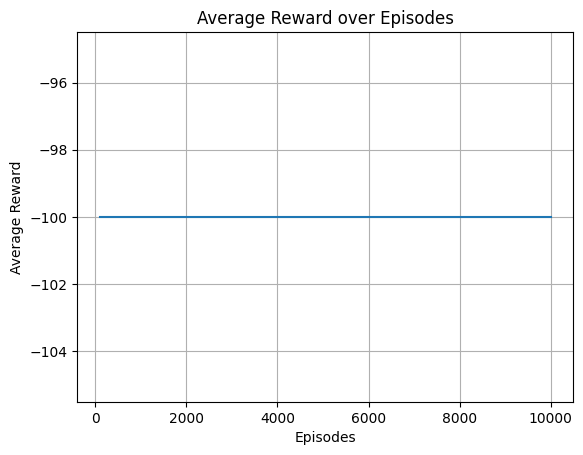

In [7]:
# Create the MountainCar environment
env = gym.make("MountainCar-v0")

# Print state space size
state_space_size = env.observation_space.shape[0]
print("State space size:", state_space_size)

# Print action space size
action_space_size = env.action_space.n
print("Action space size:", action_space_size)

def round_state(state):
    """Round the state values for discretization."""
    return tuple(round(x, 1) for x in state)

def test_algorithm(Q):
    """
    Test the learned Q-values by running the policy in the environment.

    Args:
    - Q: Dictionary containing Q-values for each state-action pair

    Returns:
    - avg_reward: Average reward obtained over 100 episodes
    """
    sum_reward = 0
    num_episodes = 100

    for _ in range(num_episodes):
        state = env.reset()
        state = round_state(state)

        for _ in range(100):
            action = np.argmax(Q[state])
            next_state, reward, done, _ = env.step(action)
            next_state = round_state(next_state)
            state = next_state
            sum_reward += reward

            if done:
                break

    avg_reward = sum_reward / num_episodes
    return avg_reward

def generate_episode(env, Q, episode):
    """
    Generate an episode using the current policy (off-policy exploration).

    Args:
    - env: OpenAI Gym environment
    - Q: Dictionary containing Q-values for each state-action pair
    - episode: List to store the generated episode (state, action, reward)

    Returns:
    - None (episode list is modified in place)
    """
    state = env.reset()
    state = round_state(state)

    for _ in range(50000):
        action = np.random.choice(np.arange(action_space_size))
        next_state, reward, done, _ = env.step(action)
        next_state = round_state(next_state)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break

def off_policy_mc_control(env, max_episodes, gamma):
    """
    Off-Policy Monte Carlo Control using Weighted Importance Sampling.

    Args:
    - env: OpenAI Gym environment
    - max_episodes: Maximum number of episodes to run the algorithm
    - gamma: Discount factor for future rewards

    Returns:
    - Q_values: Learned Q-values for each state-action pair
    """
    # Initialize Q-values and average reward list
    Q = defaultdict(lambda: np.zeros(action_space_size))
    avg_reward = []
    avg_iterations = []

    # Main loop for episodes
    for episode_num in range(1, max_episodes + 1):
        episode = []
        generate_episode(env, Q, episode)
        G = 0
        W = 1
        total_iterations = 0

        # Loop through the episode in reverse order
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward
            Q[state][action] += (W / (W + 1)) * (G - Q[state][action])
            pi_S_t = np.argmax(Q[state])
            if action != pi_S_t:
                break
            W *= 1. / action_space_size
            total_iterations += 1

        # Store average reward and iterations every 100 episodes
        if episode_num % 100 == 0:
            avg_reward.append(test_algorithm(Q))

    # Plot average reward over episodes
    plt.plot(np.arange(100, max_episodes + 1, 100), avg_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward over Episodes")
    plt.grid(True)
    plt.show()

    return Q

# Run Off-Policy Monte Carlo Control
Q_values = off_policy_mc_control(env, 10000, 0.9)


------
## **Monte Carlo (MC) Implementation and Results**

Implemented off-policy Monte Carlo control on the MountainCar-v0 environment aimed at learning an optimal policy. Despite training, the agent consistently achieved an average reward of -100. This stagnant performance suggests challenges in exploring the environment effectively and updating Q-values to reflect optimal decision-making.

The persistent -100 average reward indicates insufficient exploration or suboptimal parameter settings such as the discount factor (gamma) and exploration policy. To improve performance, enhancing exploration strategies and adjusting gamma could promote better policy learning. Additionally, exploring alternative RL algorithms tailored to MountainCar-v0's dynamics may also provide insights into more efficient learning strategies.

-----
## **Task 1: TD(0)**
Develop a TD(0) controller using:

on-policy SARSA

on-policy expected SARSA

off-policy expected SARSA with a greedy control policy.

Compare the performance of your controllers.

-----

## **1. On-Policy SARSA**

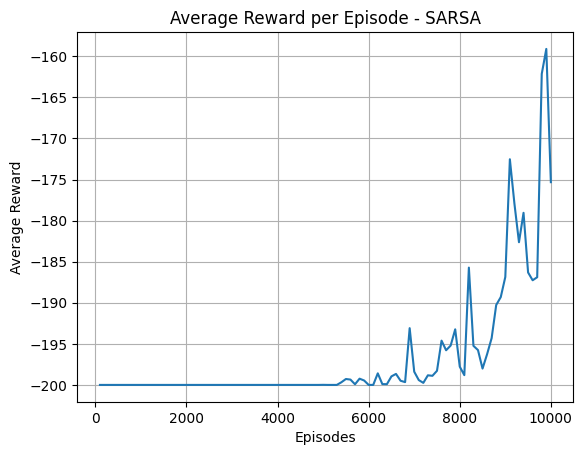

Max Average Reward is -159.1 Total Average Reward is -196.5504


In [ ]:
# Create the MountainCar environment
env = gym.make("MountainCar-v0")

# Parameters
alpha = 0.2  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.8  # Initial epsilon for epsilon-greedy policy
max_episodes = 10000  # Maximum number of episodes

def round_state(state):
    """
    Discretize the continuous state space by rounding the state values.

    Args:
    - state: Current state of the environment

    Returns:
    - Tuple: Discretized state
    """
    state[0] = round(state[0], 1)
    state[1] = round(state[1], 2)
    return tuple(state)

def initial_Q():
    """
    Initialize the Q-values uniformly for all states.

    Returns:
    - Q: Dictionary with uniformly initialized Q-values for all states
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    current_state_zero = -1.2
    for i in range(19):
        current_state_one = -0.07
        for k in range(15):
            Q[(round(current_state_zero, 1), round(current_state_one, 2))] = np.random.uniform(-1, 1, 3)
            current_state_one += 0.01
        current_state_zero += 0.1
    return Q

def epsilon_greedy_policy(state, Q, epsilon):
    """
    Epsilon-greedy policy for action selection.

    Args:
    - state: Current state of the environment
    - Q: Q-values
    - epsilon: Exploration-exploitation trade-off parameter

    Returns:
    - int: Selected action
    """
    if random.random() < epsilon:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(Q[state])

def on_policy_sarsa(env, max_episodes, alpha, gamma, epsilon):
    """
    On-policy SARSA (State-Action-Reward-State-Action) algorithm.

    Args:
    - env: OpenAI Gym environment
    - max_episodes: Maximum number of episodes to run the algorithm
    - alpha: Learning rate
    - gamma: Discount factor
    - epsilon: Initial exploration-exploitation trade-off parameter

    Returns:
    - Q: Learned Q-values
    """
    Q = initial_Q()  # Initialize Q-values
    sum_reward = 0
    total_sum_reward = 0
    avg_reward = []

    for e in range(max_episodes):  # Loop for each episode
        state = env.reset()
        state = round_state(state)

        current_epsilon = epsilon * (1 - e / max_episodes)  # Decrease epsilon over time

        action = epsilon_greedy_policy(state, Q, current_epsilon)  # Select action using epsilon-greedy policy

        for i in range(200):
            next_state, reward, done, _ = env.step(action)
            next_state = round_state(next_state)

            next_action = epsilon_greedy_policy(next_state, Q, current_epsilon)  # Select next action

            # SARSA update
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

            state = next_state
            action = next_action
            sum_reward += reward
            total_sum_reward += reward

            if done:
                break

        if (e + 1) % 100 == 0:  # Calculate average reward every 100 episodes
            avg = sum_reward / 100
            avg_reward.append(avg)
            sum_reward = 0

    # Plot average reward per episode
    l = np.arange(100, max_episodes + 1, 100).tolist()
    plt.plot(l, avg_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward per Episode - SARSA")
    plt.grid(True)
    plt.show()

    print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", total_sum_reward / max_episodes)

    return Q

# Run SARSA
Q_sarsa = on_policy_sarsa(env, max_episodes, alpha, gamma, epsilon)


The implementation of the SARSA algorithm on the MountainCar-v0 environment shows a gradual improvement in performance, as indicated by the increase in average reward over 10,000 episodes. Initially, the average reward remains around -200, suggesting that the agent struggles to learn effective policies due to the challenging nature of the environment and sparse rewards. However, around episode 6000, we observe an upward trend in the average reward, peaking at approximately -160. This indicates that the agent starts to learn and exploit more rewarding actions with significant fluctuations in performance.

The volatility in the average rewards, particularly in the latter episodes, points to the exploration-exploitation trade-off inherent in the epsilon-greedy strategy.

----------
## **2. On-Policy Expected SARSA**

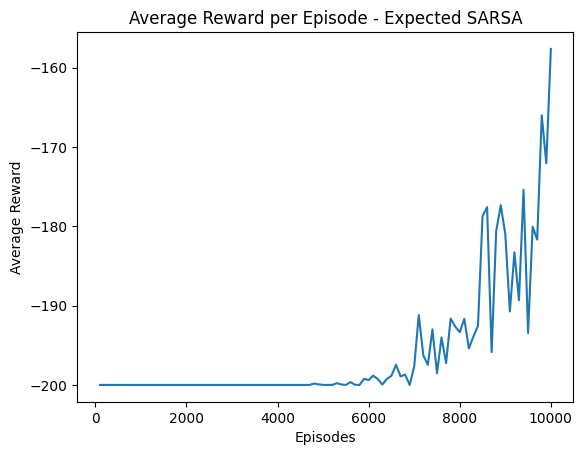

Max Average Reward is -157.64


In [ ]:
env = gym.make("MountainCar-v0")

# On-Policy Expected SARSA algorithm
def on_policy_expected_sarsa(env, max_episodes, alpha, gamma, epsilon):
    Q = initialize_Q()  # Initialize Q-values
    sum_reward = 0  # Store sum of rewards per episode
    avg_rewards = []  # Store average rewards per 100 episodes

    # Loop for each episode
    for episode in range(max_episodes):
        state = discretize_state(env.reset())  # Reset and discretize initial state

        # Update epsilon for exploration-exploitation trade-off
        current_epsilon = epsilon * (1 - episode / max_episodes)

        # Choose action from state using epsilon-greedy policy
        if np.random.rand() < 1 - current_epsilon:
            action = np.argmax(Q[state])
        else:
            action = np.random.choice(env.action_space.n)

        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)  # Take action and observe next state and reward
            next_state = discretize_state(next_state)  # Discretize next state

            # Choose next action from next state using epsilon-greedy policy
            if np.random.rand() < 1 - current_epsilon:
                next_action = np.argmax(Q[next_state])
            else:
                next_action = np.random.choice(env.action_space.n)

            # Calculate expected value for the next state
            expected_value = sum((1 - current_epsilon if k == next_action else current_epsilon / (env.action_space.n - 1)) * Q[next_state][k] for k in range(env.action_space.n))

            # Expected SARSA update
            Q[state][action] += alpha * (reward + gamma * expected_value - Q[state][action])

            state = next_state  # Update state
            action = next_action  # Update action
            sum_reward += reward  # Accumulate reward

            if done:
                break

        # Track average reward every 100 episodes
        if (episode + 1) % 100 == 0:
            avg_rewards.append(sum_reward / 100)
            sum_reward = 0  # Reset sum reward

    # Plot the average rewards
    plt.plot(np.arange(100, max_episodes + 1, 100), avg_rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward per Episode - Expected SARSA")
    plt.show()

    print("Max Average Reward is", np.max(avg_rewards))
    return Q


Q_expected_sarsa = on_policy_expected_sarsa(env, max_episodes, alpha, gamma, epsilon)


We applied the on-policy Expected SARSA algorithm to the MountainCar-v0 environment. The plot of the average reward per episode illustrates an initial phase where the average reward remains close to -200, indicating that the agent struggles to improve its performance. Around the 6000th episode, we observe some improvement, with the average reward fluctuating but showing an overall upward trend. The highest average reward achieved is approximately -157, suggesting that the agent is learning and adapting its policy over time.

------
## **3. off-policy expected SARSA with a greedy control policy.**

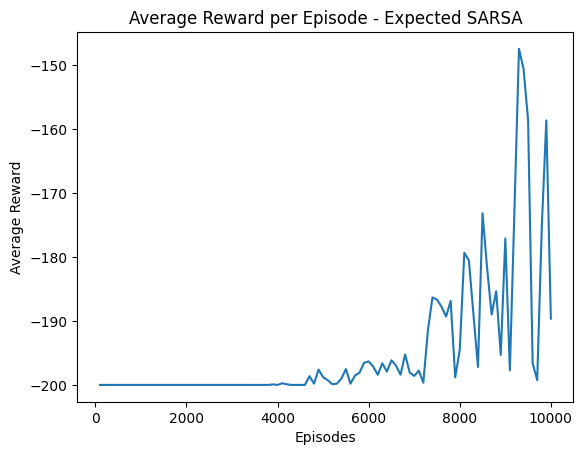

Max Average Reward is -147.42


In [ ]:
env = gym.make("MountainCar-v0")

# Off-Policy Expected SARSA algorithm
def off_policy_expected_sarsa(env, max_episodes, alpha, gamma, epsilon):
    Q = initial_Q()  # Initialize Q-values
    sum_reward = 0  # Store sum of rewards per episode
    avg_reward = []  # Store average rewards per 100 episodes

    # Loop for each episode
    for episode in range(max_episodes):
        state = round_state(env.reset())  # Reset and discretize initial state

        # Update epsilon for exploration-exploitation trade-off
        current_epsilon = epsilon * (1 - episode / max_episodes)

        for t in range(200):
            # Choose action from state using epsilon-greedy policy
            if random.random() < 1 - current_epsilon:
                action = np.argmax(Q[state])
            else:
                action = np.random.choice(env.action_space.n)

            next_state, reward, done, _ = env.step(action)  # Take action and observe next state and reward
            next_state = round_state(next_state)  # Discretize next state

            next_action = np.argmax(Q[next_state])  # Greedy action for the next state

            # Calculate expected value for the next state
            expected_value = sum(
                (1 - current_epsilon if k == next_action else current_epsilon / (env.action_space.n - 1)) * Q[next_state][k]
                for k in range(env.action_space.n)
            )

            # Expected SARSA update
            Q[state][action] += alpha * (reward + gamma * expected_value - Q[state][action])

            state = next_state  # Update state
            sum_reward += reward  # Accumulate reward

            if done:
                break

        # Track average reward every 100 episodes
        if (episode + 1) % 100 == 0:
            avg = sum_reward / 100
            avg_reward.append(avg)
            sum_reward = 0  # Reset sum reward

    # Plot the average rewards
    plt.plot(np.arange(100, max_episodes + 1, 100), avg_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward per Episode - Expected SARSA")
    plt.show()

    print("Max Average Reward is", np.max(avg_reward))
    return Q


Q_expected_sarsa = off_policy_expected_sarsa(env, max_episodes, alpha, gamma, epsilon)


We implemented the off-policy Expected SARSA algorithm with a greedy control policy to solve the MountainCar-v0 environment. The resulting plot of the average reward per episode shows an initial flat trend around -200, followed by gradual improvements starting around the 4000th episode. Despite some fluctuations, there is a noticeable upward trend, indicating that the agent is learning and improving its performance over time. The maximum average reward reached approximately -147, demonstrating significant progress from the initial state.

----------------------------

## **Compare the performance of your controllers.**



In [ ]:
import pandas as pd
from tabulate import tabulate

d = [
    ['Controllers', 'Max Reward (average)'],
    ['on-policy SARSA', -159.1],
    ['on-policy expected SARSA', -157.64],
    ['off-policy expected SARSA with a greedy control policy', -147.2]
]

df = pd.DataFrame(d[1:], columns=d[0])

print(tabulate(df, headers='keys', tablefmt='fancy_grid'))

╒════╤════════════════════════════════════════════════════════╤════════════════════════╕
│    │ Controllers                                            │   Max Reward (average) │
╞════╪════════════════════════════════════════════════════════╪════════════════════════╡
│  0 │ on-policy SARSA                                        │                -159.1  │
├────┼────────────────────────────────────────────────────────┼────────────────────────┤
│  1 │ on-policy expected SARSA                               │                -157.64 │
├────┼────────────────────────────────────────────────────────┼────────────────────────┤
│  2 │ off-policy expected SARSA with a greedy control policy │                -147.2  │
╘════╧════════════════════════════════════════════════════════╧════════════════════════╛


For Parameters

alpha = 0.2  

gamma = 0.9  

epsilon = 0.8  

max_episodes = 10000

Environment: MountainCar-v0

**off-policy expected SARSA with a greedy control policy** achieved the best
max average reward.

-------------------------------

# **Exercise 2: TD(n)**
A useful ungraded exercise. Develop code for TD(n) predication, n-step SARSA (on-policy) control and off-policy Tree Backup control.

Test it out.



Max Average Reward is -199.0 Total Average Reward is -199.0


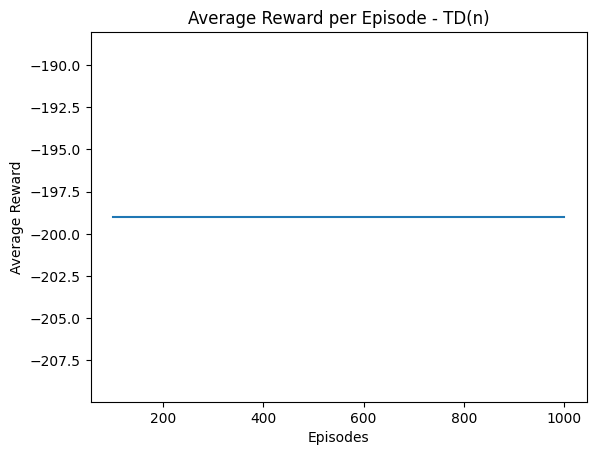

In [ ]:

def TDn(env, policy, max_episodes, alpha, gamma, n):
    ## Initialize V
    V = initial_V({})
    total_sum_reward = 0
    avg_reward = []

    ## Loop for each episode
    for e in range(max_episodes):
        state_list = []
        reward_list = []

        ## Initialize the first state
        state = env.reset()
        state = tuple(round_state(state))
        state_list.append(state)
        reward_list.append(0)

        T = math.inf

        for t in range(199):
            if t < T:
                action = policy(state)
                next_state, reward, done, info = env.step(action)
                next_state = tuple(round_state(next_state))

                state_list.append(next_state)
                reward_list.append(reward)

                if next_state not in V:
                    V[next_state] = 0

                if done:
                    T = t + 1

            tau = t - n + 1

            if tau >= 0:
                G = 0
                for i in range(int(min(T, tau + n) - (tau + 1) + 1)):
                    G += gamma ** i * reward_list[tau + 1 + i]
                if tau + n < T:
                    G += gamma ** n * V[state_list[tau + n]]
                V[state_list[tau]] += alpha * (G - V[state_list[tau]])

            total_sum_reward += reward

            if tau == T - 1:
                break

        if (e + 1) % 100 == 0:
            avg = total_sum_reward / 100
            avg_reward.append(avg)
            total_sum_reward = 0

    l = np.arange(100, max_episodes + 1, 100).tolist()
    plt.plot(l, avg_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward per Episode - TD(n)")

    print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", np.mean(avg_reward))

    return V

# Define a sample policy
def sample_policy(state):
    return env.action_space.sample()

# Test usage (lesser episodes for testing purpose)
env = gym.make('MountainCar-v0')
V = TDn(env, sample_policy, 1000, 0.2, 0.9, n=4)


In [16]:
def n_step_Sarsa(env, max_episodes, alpha, gamma, epsilon, n):
    ## initial Q
    Q = initial_Q({})
    total_sum_reward = 0
    sum_reward = 0
    avg_reward = []

    ## Loop for each episode
    for e in range(max_episodes):
        state_list = []
        action_list = []
        reward_list = []

        ## Initial the State 0
        state = env.reset()
        state = tuple(round_state(state))
        state_list.append(state)
        reward_list.append(-1)


        current_epsilon = epsilon * (1 - e / max_episodes)

        ## Choose A from S using epsilon greedy policy
        rand = random.random()
        if rand < 1 - current_epsilon:
            action = np.argmax(Q[state])
        else:
            action = np.random.choice(np.arange(env.action_space.n))

        action_list.append(action)
        T = math.inf

        for t in range(199):
            if t < T:
                action = action_list[t]
                next_state, reward, done, info = env.step(action)
                next_state = tuple(round_state(next_state))

                state_list.append(next_state)
                reward_list.append(reward)

                if next_state not in Q:
                    Q[next_state] = np.random.uniform(-1, 1, env.action_space.n)

                if done:
                    T = t + 1
                else:
                    ## Choose A' from S' using epsilon greedy policy
                    rand = random.random()
                    if rand < 1 - current_epsilon:
                        next_action = np.argmax(Q[next_state])
                    else:
                        next_action = np.random.choice(np.arange(env.action_space.n))

                    action_list.append(next_action)

            tau = t - n + 1

            if tau >= 0:
                G = 0
                for i in range(int(min(T, tau + n) - (tau + 1) + 1)):
                    G += gamma ** i * reward_list[tau + 1 + i]
                if tau + n < T:
                    G += gamma ** n * Q[state_list[tau + n]][action_list[tau + n]]
                Q[state_list[tau]][action_list[tau]] += alpha * (G - Q[state_list[tau]][action_list[tau]])

            sum_reward += reward
            total_sum_reward += reward

            if tau == T - 1:
                break

        if (e + 1) % 100 == 0:
            avg = sum_reward / 100
            avg_reward.append(avg)
            sum_reward = 0

    l = np.arange(100, max_episodes + 1, 100).tolist()
    plt.plot(l, avg_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward per Episode - n-step SARSA")

    print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", total_sum_reward / max_episodes)

    return Q

# Test usage (lesser episodes for testing purpose)
env = gym.make('MountainCar-v0')
Q = n_step_Sarsa(env, 1000, 0.2, 0.9, 0.8, n=4)


<ipython-input-14-bcb45045d469>:80: RuntimeWarning: overflow encountered in scalar add
  G += gamma ** n * np.dot([current_epsilon / env.action_space.n if a != np.argmax(Q[state_list[k]]) else (1 - current_epsilon + (current_epsilon / env.action_space.n)) for a in range(env.action_space.n)], Q[state_list[k]])
<ipython-input-14-bcb45045d469>:81: RuntimeWarning: invalid value encountered in scalar subtract
  Q[state_list[tau]][action_list[tau]] += alpha * (G - Q[state_list[tau]][action_list[tau]])


Max Average Reward is -200.0 Total Average Reward is -200.0


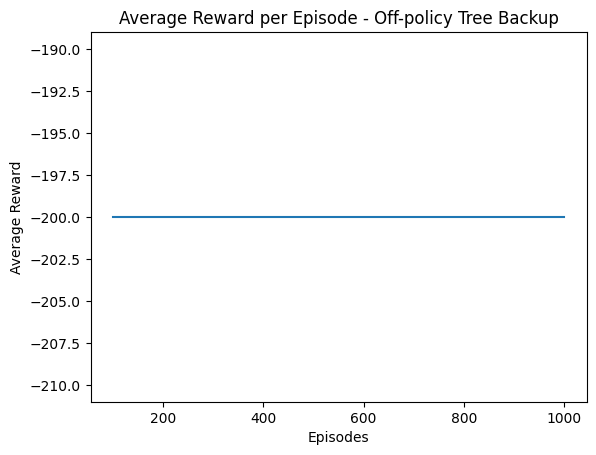

In [14]:
def off_policy_tree_backup(env, max_episodes, alpha, gamma, epsilon, n):
    # Initialize Q
    Q = initial_Q({})
    sum_reward = 0
    total_sum_reward = 0
    avg_reward = []

    # Loop for each episode
    for e in range(max_episodes):
        state_list = []
        action_list = []
        reward_list = []

        # Initialize state
        state = env.reset()
        state = tuple(round_state(state))
        state_list.append(state)
        reward_list.append(0)

        # Update epsilon
        current_epsilon = epsilon * (1 - e / max_episodes)

        # Choose action using epsilon-greedy policy
        if random.random() < 1 - current_epsilon:
            action = np.argmax(Q[state])
        else:
            action = np.random.choice(env.action_space.n)

        action_list.append(action)
        T = math.inf

        for t in range(200):
            if t < T:
                next_state, reward, done, _ = env.step(action_list[t])
                next_state = tuple(round_state(next_state))

                state_list.append(next_state)
                reward_list.append(reward)

                if next_state not in Q:
                    Q[next_state] = np.random.uniform(-1, 1, env.action_space.n)

                if done:
                    T = t + 1
                else:
                    if random.random() < 1 - current_epsilon:
                        next_action = np.argmax(Q[next_state])
                    else:
                        next_action = np.random.choice(env.action_space.n)

                    action_list.append(next_action)

            tau = t - n + 1
            if tau >= 0:
                G = Q[state_list[tau]][action_list[tau]]
                for k in range(tau + 1, int(min(tau + n, T))):
                    G += gamma ** (k - tau) * reward_list[k]
                    if k < T:
                        G += gamma ** n * np.dot([current_epsilon / env.action_space.n if a != np.argmax(Q[state_list[k]]) else (1 - current_epsilon + (current_epsilon / env.action_space.n)) for a in range(env.action_space.n)], Q[state_list[k]])
                Q[state_list[tau]][action_list[tau]] += alpha * (G - Q[state_list[tau]][action_list[tau]])

            sum_reward += reward
            total_sum_reward += reward

            if tau == T - 1:
                break

        if (e + 1) % 100 == 0:
            avg = sum_reward / 100
            avg_reward.append(avg)
            sum_reward = 0

    episodes = np.arange(100, max_episodes + 1, 100).tolist()
    plt.plot(episodes, avg_reward)
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward")
    plt.title("Average Reward per Episode - Tree Backup")

    print("Max Average Reward is", np.max(avg_reward), "Total Average Reward is", total_sum_reward / max_episodes)

    return Q

# Test usage - Lesser episodes for testing only.
env = gym.make('MountainCar-v0')
Q = off_policy_tree_backup(env, 1000, 0.2, 0.9, 0.8, n=3)


-------
# **Task 2: TD(2), TD(3), TD(4)**
Code controllers for TD(2), TD(3), and TD(4) using n-SARSA. Assess performance and compare against TD(0) and each other.

You may choose to use your work from Ex 2 for this (if you did Ex 2); otherwise you can code specific solvers for TD(2/3/4).

Extra practice:

Assess the performance of Tree Backup for TD(2), TD(3), and TD(4) versus the respective n-SARSA controller.

-----------

## TD(2)

Max Average Reward is -160.82 Total Average Reward is -194.6747


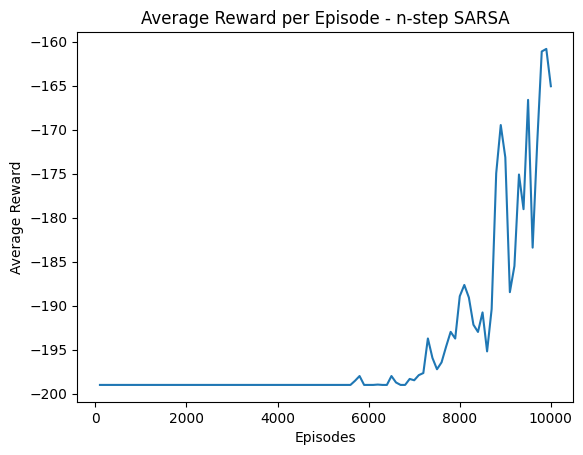

In [ ]:
# usage for TD(2) - Using the already coded function from ex.2
env = gym.make('MountainCar-v0')
Q_td2 = n_step_Sarsa(env, 10000, 0.2, 0.9, 0.8, n=2)



##TD(3)

Max Average Reward is -155.61 Total Average Reward is -194.6486


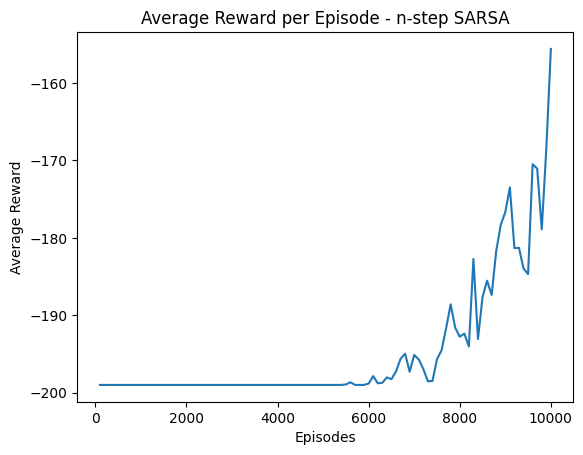

In [ ]:
#  usage for TD(3) - Using the already coded function from ex.2
env = gym.make('MountainCar-v0')

Q_td3 = n_step_Sarsa(env, 10000, 0.2, 0.9, 0.8, n=3)



##TD(4)

Max Average Reward is -148.11 Total Average Reward is -194.1278


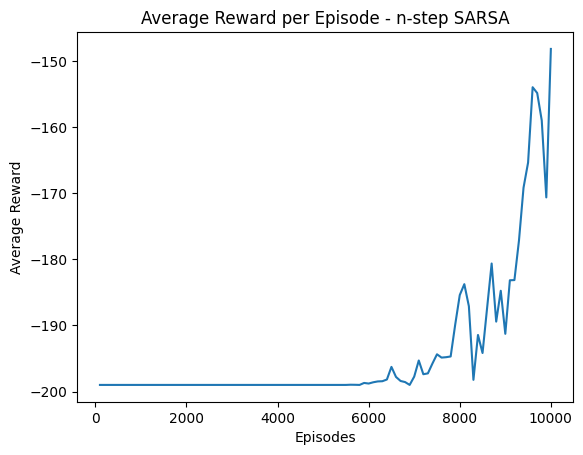

In [ ]:
#  usage for TD(4) - Using the already coded function from ex.2
env = gym.make('MountainCar-v0')

Q_td4 = n_step_Sarsa(env, 10000, 0.2, 0.9, 0.8, n=4)

In [ ]:
d = [
    ['Controllers', 'Max Reward (average)'],
    ['TD (0)', -159.1],
    ['TD (2)', -160.82],
    ['TD (3)', -155.61],
    ['TD (4)', -148.11],
]

df = pd.DataFrame(d[1:], columns=d[0])

print(tabulate(df, headers='keys', tablefmt='fancy_grid'))

╒════╤═══════════════╤════════════════════════╕
│    │ Controllers   │   Max Reward (average) │
╞════╪═══════════════╪════════════════════════╡
│  0 │ TD (0)        │                -159.1  │
├────┼───────────────┼────────────────────────┤
│  1 │ TD (2)        │                -160.82 │
├────┼───────────────┼────────────────────────┤
│  2 │ TD (3)        │                -155.61 │
├────┼───────────────┼────────────────────────┤
│  3 │ TD (4)        │                -148.11 │
╘════╧═══════════════╧════════════════════════╛


-----
# **Extra practice:**